<a href="https://colab.research.google.com/github/hazrakeruboO/DS-Colabs/blob/main/Copy_of_Python_Programming_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="green">*To start working on this notebook, or any other notebook that we will use in the Moringa Data Science Course, we will need to save our own copy of it. We can do this by clicking File > Save a Copy in Drive. We will then be able to make edits to our own copy of this notebook.*</font>

# Python Programming: Logistic Regression

## Importing Our Libraries

In [1]:
# Importing our libraries
#
import pandas as pd
import seaborn as sb

## Example 

In [2]:
# Example 1
# ---
# You are tasked to complete the analysis of what sorts of people were likely to survive the titanic. 
# Specifically you are requested to apply logistic regression modelining 
# to predict which passengers survived the tragedy.
# ---
# Dataset url = http://bit.ly/TitanicTrainDataset
# ---
# Survived - Survival (0 = No; 1 = Yes)
# Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
# Name - Name
# Sex - Sex
# Age - Age
# SibSp - Number of Siblings/Spouses Aboard
# Parch - Number of Parents/Children Aboard
# Ticket - Ticket Number
# Fare - Passenger Fare (British pound)
# Cabin - Cabin
# Embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

In [3]:
# Reading in the dataset using the Pandas
# 
titanic = pd.read_csv("http://bit.ly/TitanicTrainDataset")
titanic.columns = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


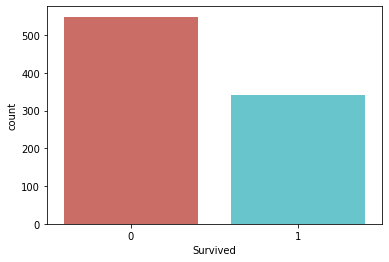

In [4]:
# Checking that our target variable is binary
# Since we are building a model to predict survival of passangers from the Titanic, 
# our target is going to be "Survived" variable from the titanic dataframe. 
# To make sure that it's a binary variable, let's use Seaborn's countplot() function.
# 
sb.countplot(x='Survived',data=titanic, palette='hls')

# from the output we see that the Survived variable is binary (0 - did not survive / 1 - survived)

In [5]:
# Checking for missing values
# 
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
# Understanding the dataset abit more
# 
titanic.info()

# Ok, so there are only 891 rows in the titanic data frame. 
# Cabin is almost all missing values, so we can drop that variable completely, 
# but what about age? Age seems like a relevant predictor for survival right? 
# We'd want to keep the variables, but it has 177 missing values.
# We are going to need to find a way to approximate for those missing values!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
# Taking care of missing values
# So let's just go ahead and drop all the variables that aren't relevant for predicting survival. We should at least keep the following:
# ---
# Survived - This variable is obviously relevant.
# Pclass - Does a passenger's class on the boat affect their survivability?
# Sex - Could a passenger's gender impact their survival rate?
# Age - Does a person's age impact their survival rate?
# SibSp - Does the number of relatives on the boat (that are siblings or a spouse) affect a person survivability? Probability
# Parch - Does the number of relatives on the boat (that are children or parents) affect a person survivability? Probability
# Fare - Does the fare a person paid effect his survivability? Maybe - let's keep it.
# Embarked - Does a person's point of embarkation matter? It depends on how the boat was filled... Let's keep it.
# What about a person's name, ticket number, and passenger ID number? They're irrelavant for predicting survivability. 
# And as we recall, the cabin variable is almost all missing values, so we can just drop all of these.
# 
titanic_data = titanic.drop(['PassengerId','Name','Ticket','Cabin'], 1)
titanic_data.head()

# Now we have the dataframe reduced down to only relevant variables, but now we need to deal with the missing values in the age variable.

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


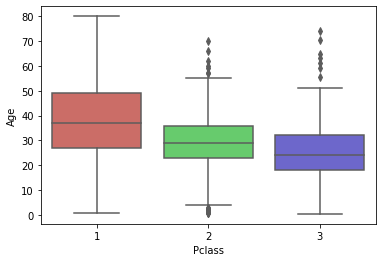

In [8]:
# Imputing missing values
# ---
# Let's look at how passenger age is related to their class as a passenger on the boat.
# 
sb.boxplot(x='Pclass', y='Age', data=titanic_data, palette='hls')

In [9]:
titanic_data.head()

# Speaking roughly, we could say that the younger a passenger is, the more likely it is for them to be in 3rd class. 
# The older a passenger is, the more likely it is for them to be in 1st class. 
# So there is a loose relationship between these variables. 
# So, let's write a function that approximates a passengers age, based on their class. 
# From the box plot, it looks like the average age of 1st class passengers 
# is about 37, 2nd class passengers is 29, and 3rd class pasengers is 24.

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [10]:
# So let's write a function that finds each null value in the Age variable, and for each null, 
# checks the value of the Pclass and assigns an age value according to the average age of passengers in that class.
#
def age_approx(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

In [11]:
# When we apply the function and check again for null values, we see that there are no more null values in the age variable.
#
titanic_data['Age'] = titanic_data[['Age', 'Pclass']].apply(age_approx, axis=1)
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [12]:
# There are 2 null values in the embarked variable. We can drop those 2 records 
# without loosing too much important information from our dataset, so we will do that.
#
titanic_data.dropna(inplace=True)
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [13]:
# Converting categorical variables to a dummy indicators
# ---
# The next thing we need to do is reformat our variables so that they work with the model. 
# Specifically, we need to reformat the Sex and Embarked variables into numeric variables.
#
gender = pd.get_dummies(titanic_data['Sex'],drop_first=True)
gender.head()

,male
0,1
1,0
2,0
3,0
4,1


In [14]:
embark_location = pd.get_dummies(titanic_data['Embarked'],drop_first=True)
embark_location.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [15]:
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [16]:
titanic_data.drop(['Sex', 'Embarked'],axis=1,inplace=True)
titanic_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [17]:
titanic_dmy = pd.concat([titanic_data,gender,embark_location],axis=1)
titanic_dmy.head()

# Now we have a dataset with all the variables in the correct format!

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


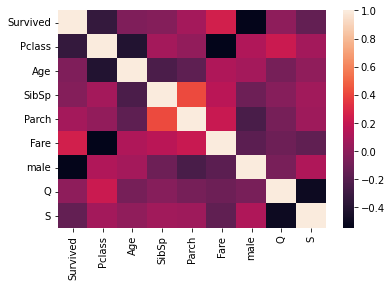

In [18]:
# Checking for independence between features¶
# 
sb.heatmap(titanic_dmy.corr())  

In [19]:
# Fare and Pclass are not independent of each other, so I am going to drop these.
# 
titanic_dmy.drop(['Fare', 'Pclass'],axis=1,inplace=True)
titanic_dmy.head()

,Survived,Age,SibSp,Parch,male,Q,S
0,0,22.0,1,0,1,0,1
1,1,38.0,1,0,0,0,0
2,1,26.0,0,0,0,0,1
3,1,35.0,1,0,0,0,1
4,0,35.0,0,0,1,0,1


In [20]:
# Checking that your dataset size is sufficient
# We have 6 predictive features that remain. The rule of thumb is 50 records per feature 
# so we need to have at least 300 records in this dataset. Let's check again.
#
titanic_dmy.info()

              
# From the output we have 889 records so we are fine.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Age       889 non-null    float64
 2   SibSp     889 non-null    int64  
 3   Parch     889 non-null    int64  
 4   male      889 non-null    uint8  
 5   Q         889 non-null    uint8  
 6   S         889 non-null    uint8  
dtypes: float64(1), int64(3), uint8(3)
memory usage: 37.3 KB


In [21]:
# Splitting our dataset
#
X = titanic_dmy.drop("Survived",axis=1)
y = titanic_dmy["Survived"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

In [22]:
# Fitting our model
# 
from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
# Using our model to make a prediction
#
y_pred = LogReg.predict(X_test)

In [24]:
# Evaluating the model
#
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

# The results from the confusion matrix tell us that 137 and 69 are the number of correct predictions. 
# 34 and 27 are the number of incorrect predictions.

array([[137,  27],
       [ 34,  69]])

## <font color="green">Challenge 1</font>

In [25]:
# Challenge 1
# ---
# Question: Use the Iris dataset to build a regression model to predict the type of iris flower
# ---
# Dataset url = http://bit.ly/IrisDataset
# ---
#
OUR CODE GOES HERE

SyntaxError: ignored

## <font color="green">Challenge 2</font>

In [ ]:
# Challenge 2
# ---
# Question: Create a regression model that can predict whether an application will be admitted to the university or not.
# ---
# Dataset url = http://bit.ly/MarksDataset
# ---
#
marks=pd.read_txt('http://bit.ly/MarksDataset')
marks.head()

In [ ]:
def load_data(path, header):
    marks_df = pd.read_csv(path, header=header)
    return marks_df


if __name__ == "__main__":
    # load the data from the file
    data = load_data("data/marks.txt", None)

   

   
  

In [ ]:

    # X = feature values, all the columns except the last column
    X = data.iloc[:, :-1]

    # y = target values, last column of the data frame
    y = data.iloc[:, -1]


In [ ]:
 # filter out the applicants that got admitted
    admitted = data.loc[y == 1]

    # filter out the applicants that din't get admission
    not_admitted = data.loc[y == 0]

   


In [ ]:
 # plots
    plt.scatter(admitted.iloc[:, 0], admitted.iloc[:, 1], s=10, label='Admitted')
    plt.scatter(not_admitted.iloc[:, 0], not_admitted.iloc[:, 1], s=10,
                label='Not Admitted')

In [ ]:

    # preparing the data for building the model

    X = np.c_[np.ones((X.shape[0], 1)), X]
    y = y[:, np.newaxis]
    theta = np.zeros((X.shape[1], 1))

In [ ]:
 # Logistic Regression from scratch using Gradient Descent
    model = LogisticRegressionUsingGD()
    model.fit(X, y, theta)
    accuracy = model.accuracy(X, y.flatten())
    parameters = model.w_
    print("The accuracy of the model is {}".format(accuracy))
    print("The model parameters using Gradient descent")
    print("\n")
    print(parameters)


In [ ]:
  # plotting the decision boundary
    # As there are two features
    # wo + w1x1 + w2x2 = 0
    # x2 = - (wo + w1x1)/(w2)

    x_values = [np.min(X[:, 1] - 2), np.max(X[:, 2] + 2)]
    y_values = - (parameters[0] + np.dot(parameters[1], x_values)) / parameters[2]

    plt.plot(x_values, y_values, label='Decision Boundary')
    plt.legend()
    plt.show()

  

In [ ]:
  # Using scikit-learn
    model = LogisticRegression()
    model.fit(X, y)
    parameters = model.coef_
    print("The model parameters using scikit learn")
    print(parameters)

## <font color="green">Challenge 3</font>

In [2]:
# Challenge 3
# ---
# Question: Predict if the client will subscribe a term deposit (variable y).
# ---
# Dataset url = http://bit.ly/BankingDataset
# ---
# 
import matplotlib.pyplot as plt
import seaborn as sns
import math
banking=pd.read_csv('http://bit.ly/BankingDataset')
banking.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,210,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,138,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,339,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,185,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,137,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [27]:
banking.shape

(41188, 21)

In [28]:
banking.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype='object')

In [29]:
banking.previous

0        0
1        0
2        2
3        0
4        1
        ..
41183    0
41184    0
41185    0
41186    0
41187    0
Name: previous, Length: 41188, dtype: int64

In [30]:
banking.campaign

0        1
1        1
2        3
3        2
4        1
        ..
41183    1
41184    2
41185    3
41186    2
41187    4
Name: campaign, Length: 41188, dtype: int64

In [31]:
banking.y

0        0
1        0
2        1
3        0
4        1
        ..
41183    0
41184    0
41185    0
41186    0
41187    0
Name: y, Length: 41188, dtype: int64

In [ ]:
sns.countplot(x='marital', data=banking)


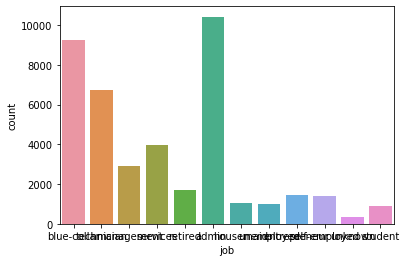

In [32]:
sns.countplot(x='job', data=banking)

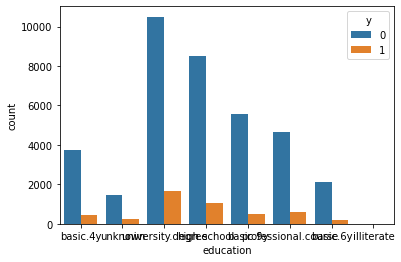

In [46]:
sns.countplot(x='education',hue='y', data=banking)

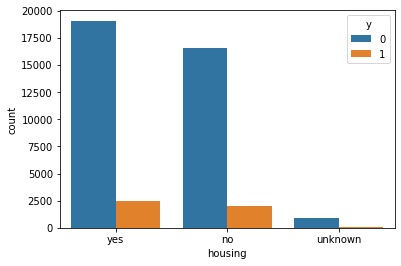

In [44]:
sns.countplot(x='housing',hue='y', data=banking)

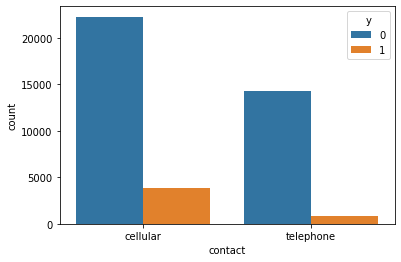

In [43]:
sns.countplot(x='contact', hue='y', data=banking)

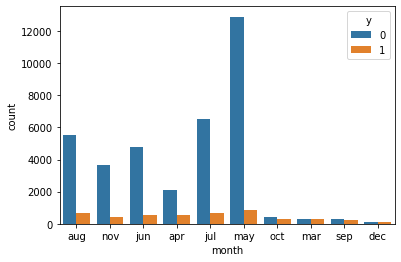

In [42]:
sns.countplot(x='month',hue='y' ,data=banking)

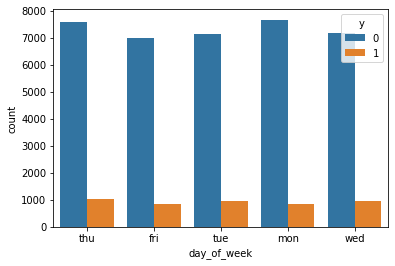

In [40]:
sns.countplot(x='day_of_week',hue='y',data=banking)

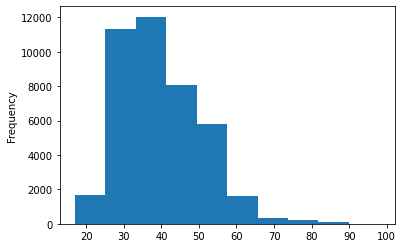

In [38]:
banking['age'].plot.hist()

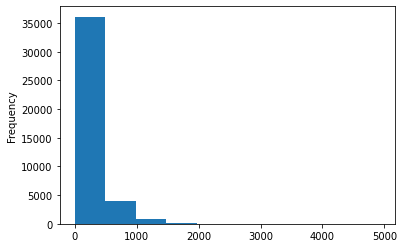

In [3]:
banking['duration'].plot.hist()#(bin=20,figsize=(10,5))

In [4]:
banking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp_var_rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

In [5]:
banking.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

In [6]:
banking.corr()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725,0.030399
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703,0.405274
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095,-0.066357
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605,-0.324914
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333,0.230181
emp_var_rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970,-0.298334
cons_price_idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034,-0.136211
cons_conf_idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513,0.054878
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154,-0.307771
nr_employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000,-0.354678


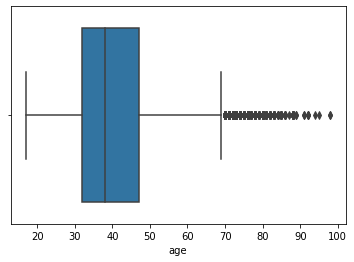

In [7]:
sns.boxplot(x='age',data=banking)

## <font color="green">Challenge 4</font>

In [ ]:
# Challenge 4
# ---
# Question: Create a logistic regression model determine whether a user purchased a particular product.
# ---
# Dataset url = http://bit.ly/SocialNetworkAdsDataset
# ---
#
OUR CODE GOES HERE

## <font color="green">Challenge 5</font>

In [ ]:
# Challenge 5
# ---
# Question: Create model to determine whether a student will default on their student loans.
# ---
# Dataset url = http://bit.ly/StudentDefaultDataset
# ---
OUR CODE GOES HERE